In [1]:
import pandas as pd
import os

import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits
import astropy.units as u
from astropy.table import Table, vstack
import astropy
from astropy.coordinates import SkyCoord
import getpass

import lsst.afw.display as afwDisplay
import lsst.afw.geom as afwGeom
import lsst.afw.image as afwImage
import lsst.afw.math as afwMath
from lsst.daf.butler import Butler
from lsst.daf.butler.registry import ConflictingDefinitionError
import lsst.geom as geom
from lsst.source.injection import ingest_injection_catalog, generate_injection_catalog
from lsst.source.injection import VisitInjectConfig, VisitInjectTask
from lsst.ip.diffim.subtractImages import AlardLuptonSubtractTask, AlardLuptonSubtractConfig

from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask
from lsst.meas.base import ForcedMeasurementTask
import lsst.daf.base as dafBase
import lsst.afw.table as afwTable

In [2]:
!pwd

/pscratch/sd/t/taceroc/LE_inj


In [3]:
# repo = '/global/cfs/cdirs/lsst/production/gen3/DC2/Run2.2i/repo/butler-schema-migration.yaml'
# butler = dafPersist.Butler(repo)

# Define repo and collections

I followed some documentation:

https://github.com/LSSTDESC/ComputingInfrastructure/issues/62

https://confluence.slac.stanford.edu/spaces/LSSTDESC/pages/388840402/DC2+Data+with+the+Gen3+Butler

In [4]:
repo = '/global/cfs/cdirs/lsst/production/gen3/DC2/Run3.1i/repo'
# These are the collections containing the Y1 processed visit images, etc..
collections = ['u/descdm/sfp_ddf_visits_part_00',
               'u/descdm/sfp_ddf_visits_part_01',
              ]
# collections = ['u/jchiang8/coadds_ddf_y1-y2_4848_assembleCoadd']

## Extract calexp

In [5]:
calexp_butler = Butler(repo, collections=collections)

In [6]:
#At the moment only tracts 35, 36, 42 and 43 in patch 4848 have 2-years depth coadds. We therefore limit the dataset query to this patch.
tract = 4848
where = f"instrument='LSSTCam-imSim' AND skymap='DC2' AND \
          tract={tract} AND band='g'"
calexp_g_DatasetRefs = sorted(list(set(calexp_butler.registry.queryDatasets('calexp', where=where))))
print(f'Identified {len(calexp_g_DatasetRefs)} calexp DatasetRefs')

Identified 2103 calexp DatasetRefs


## Select a dataset id

In [8]:
dataId = calexp_g_DatasetRefs[5].dataId
print(f"{dataId = }")

dataId = {instrument: 'LSSTCam-imSim', detector: 5, visit: 195558, band: 'g', day_obs: 20220919, physical_filter: 'g_sim_1.4'}


In [9]:
calexp = calexp_butler.get('calexp', dataId=dataId)

# Plot LE fits

In [11]:
stamp_img_hdu_165 = fits.open('fits/surface_valuesInfPlane_dt0_loop_ct165_loc[0.9, -1.3, 1, -32.6156]_dz0.06_w673_angle[30, 155].fits')
fits_img_165 = stamp_img_hdu_165[0].data
stamp_img_hdu_165.close()

stamp_img_hdu_230 = fits.open('fits/surface_valuesInfPlane_dt0_loop_ct230_loc[0.9, -1.3, 1, -32.6156]_dz0.06_w673_angle[30, 155].fits')
fits_img_230 = stamp_img_hdu_230[0].data
stamp_img_hdu_230.close()

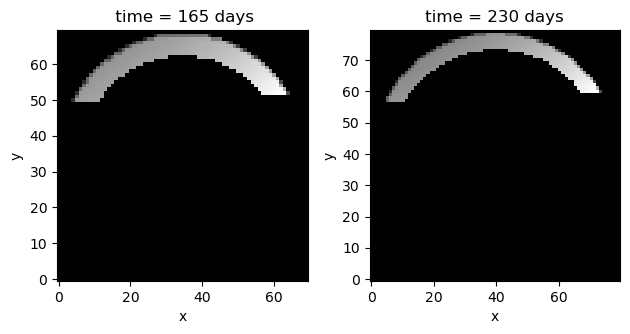

In [17]:
fig = plt.figure()
plt.subplot(121)
im = plt.imshow(fits_img_165, cmap='gray', origin='lower')
plt.title(" time = 165 days")
# plt.colorbar(im)
plt.xlabel('x')
plt.ylabel('y')


plt.subplot(122)
im = plt.imshow(fits_img_230, cmap='gray', origin='lower')
# plt.colorbar(im)
plt.title("time = 230 days")
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()

In [18]:
# stamp_img_hdu_med = fits.open('output_file1_median.fits')
# fig = plt.figure()
# plt.subplot()
# im = plt.imshow(stamp_img_hdu_med[0].data, cmap='gray', origin='lower')
# plt.colorbar(im)
# plt.xlabel('x')
# plt.ylabel('y')
# plt.show()

In [19]:
calexp.getWcs()

FITS standard SkyWcs:
Sky Origin: (52.4438133835, -28.7777801320)
Pixel Origin: (2019.96, 1975.72)
Pixel Scale: 0.199844 arcsec/pixel

In [20]:
calexp.getBBox()

Box2I(corner=Point2I(0, 0), dimensions=Extent2I(4072, 4000))

In [21]:
# calexp.containsSkyCoords(53.132*u.deg, -28.398*u.deg)

In [22]:
# help(calexp.getWcs())

## Define location of LE injection on calexp

Use pixel location, then convert to radec

check that calexp contain the location

In [23]:
radec = calexp.getWcs().pixelToSky(geom.Point2D(200,200))

In [24]:
calexp.containsSkyCoords(radec.getRa().asAngularUnits(geom.degrees)*u.deg, radec.getDec().asAngularUnits(geom.degrees)*u.deg)

array([ True])

In [25]:
# radec = geom.SpherePoint(my_injection_catalog_stamp["ra"], my_injection_catalog_stamp["dec"], geom.degrees)
# xy = calexp.getWcs().skyToPixel(radec)

# Create injection catalog

I followed DP02_14_Injecting_Synthetic_Sources.ipynb

In [26]:
def create_table_catalog(ids, ra, dec, mag, path_stamp):
    
    my_injection_catalog_stamp = Table(
    {
        'injection_id': [ids],
        'ra': [ra],
        'dec': [dec],
        'source_type': ['Stamp'],
        'mag': [mag],
        'stamp': [path_stamp],
    }
)
    return my_injection_catalog_stamp

In [27]:
path_stamps_165 = 'fits/surface_valuesInfPlane_dt0_loop_ct165_loc[0.9, -1.3, 1, -32.6156]_dz0.06_w673_angle[30, 155].fits'
path_stamps_230 = 'fits/surface_valuesInfPlane_dt0_loop_ct230_loc[0.9, -1.3, 1, -32.6156]_dz0.06_w673_angle[30, 155].fits'
mag = 24
ids = 0
ra = round(radec.getRa().asAngularUnits(geom.degrees),2)
dec = round(radec.getDec().asAngularUnits(geom.degrees),2)

In [28]:
my_injection_catalog_stamp = create_table_catalog(ids, ra, dec, mag, path_stamps_165)

In [29]:
os.getenv("USER")

'taceroc'

In [30]:
# !butler remove-runs /global/cfs/cdirs/lsst/production/gen3/DC2/Run3.1i/repo u/taceroc/test_LEinjection_inputs

## Name the injection catalog collection

In [31]:
user = os.getenv("USER")
# butler remove-runs dp02 u/taceroc/test_LEinjection_inputs_2
INJECTION_CATALOG_COLLECTION = f"u/{user}/test_LEinjection_inputs_3132025_165"

In [49]:
# Butler(repo, writeable=True).removeRuns(names=['u/taceroc/test_LEinjection_inputs'])

In [33]:
writeable_butler = Butler(repo, writeable=True)

In [34]:
# help(Butler)

## Ingest catalog

In [35]:
try:
    my_injected_datasetRefs = ingest_injection_catalog(
        writeable_butler=writeable_butler,
        table=my_injection_catalog_stamp,
        band=dataId["band"],
        output_collection=INJECTION_CATALOG_COLLECTION,
    )
except ConflictingDefinitionError:
    print(f"Found an existing collection named INJECTION_CATALOG_COLLECTION={INJECTION_CATALOG_COLLECTION}.")
    print("\nNOTE THAT IF YOU SEE THIS MESSAGE, YOUR CATALOG WAS NOT INGESTED."
          "\nYou may either continue with the pre-existing catalog, or choose a new"
          " name and re-run the previous cell and this one to ingest a new catalog.")

In [36]:
psf = calexp.getPsf()
photo_calib = calexp.getPhotoCalib()
wcs = calexp.getWcs()

# Inject catalogs

In [37]:
injection_refs = calexp_butler.registry.queryDatasets(
    "injection_catalog",
    band=dataId["band"],
    collections=INJECTION_CATALOG_COLLECTION,
)
injection_catalogs = [
    calexp_butler.get(injection_ref) for injection_ref in injection_refs
]

In [38]:
radec = geom.SpherePoint(my_injection_catalog_stamp["ra"], my_injection_catalog_stamp["dec"], geom.degrees)
xy = calexp.getWcs().skyToPixel(radec)

In [39]:
xy

Point2D(118.5837764614871, 206.84428983567045)

In [40]:
inject_config = VisitInjectConfig()

inject_task = VisitInjectTask(config=inject_config)

In [41]:
injected_output = inject_task.run(
    injection_catalogs=injection_catalogs,
    input_exposure=calexp.clone(),
    psf=psf,
    photo_calib=photo_calib,
    wcs=wcs,
)
injected_exposure = injected_output.output_exposure
injected_catalog = injected_output.output_catalog

In [43]:
xy

Point2D(118.5837764614871, 206.84428983567045)

# Need to inject in the same calexp? but different LEs

In [44]:
my_injection_catalog_stamp = create_table_catalog(ids, ra, dec, mag, path_stamps_230)
INJECTION_CATALOG_COLLECTION = f"u/{user}/test_LEinjection_inputs_3132025_230"
writeable_butler = Butler(repo, writeable=True)
try:
    my_injected_datasetRefs = ingest_injection_catalog(
        writeable_butler=writeable_butler,
        table=my_injection_catalog_stamp,
        band=dataId["band"],
        output_collection=INJECTION_CATALOG_COLLECTION,
    )
except ConflictingDefinitionError:
    print(f"Found an existing collection named INJECTION_CATALOG_COLLECTION={INJECTION_CATALOG_COLLECTION}.")
    print("\nNOTE THAT IF YOU SEE THIS MESSAGE, YOUR CATALOG WAS NOT INGESTED."
          "\nYou may either continue with the pre-existing catalog, or choose a new"
          " name and re-run the previous cell and this one to ingest a new catalog.")

injection_refs = calexp_butler.registry.queryDatasets(
    "injection_catalog",
    band=dataId["band"],
    collections=INJECTION_CATALOG_COLLECTION,
)
injection_catalogs = [
    calexp_butler.get(injection_ref) for injection_ref in injection_refs
]


inject_config = VisitInjectConfig()
inject_task = VisitInjectTask(config=inject_config)

injected_output = inject_task.run(
    injection_catalogs=injection_catalogs,
    input_exposure=calexp.clone(),
    psf=psf,
    photo_calib=photo_calib,
    wcs=wcs,
)
injected_exposure_230 = injected_output.output_exposure
injected_catalog_230 = injected_output.output_catalog

In [45]:
afwDisplay.setDefaultBackend('matplotlib')
plt.style.use('tableau-colorblind10')

## Plot calexp 165 and calexp 230

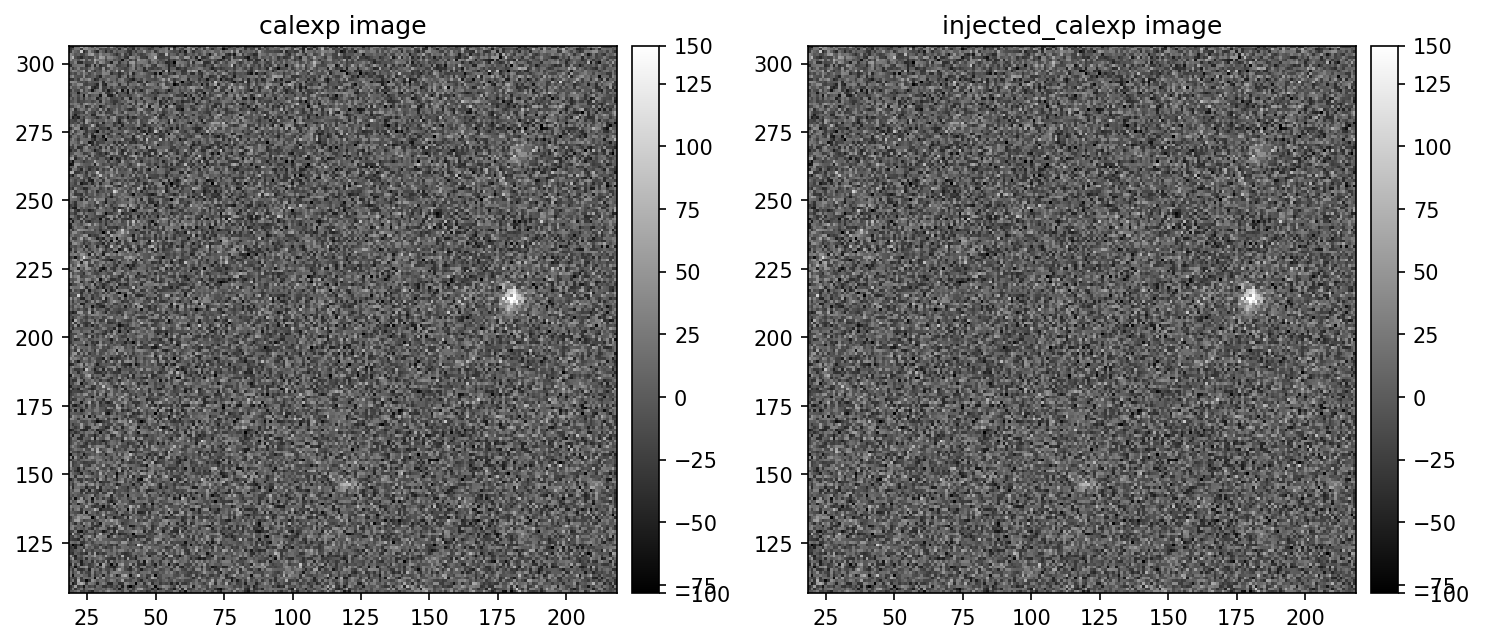

In [46]:
# plot_injected_calexp = injected_exposure.clone()

fig, ax = plt.subplots(1, 2, figsize=(10, 6), dpi=150)

plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
display0.scale('linear', 'zscale')
# display0.scale('linear', min=-20, max=150)
display0.mtv(injected_exposure.image[xy[0]+100:xy[0]-100, xy[1]+100:xy[1]-100])#[3510:3560, 1750:1800])
plt.title('calexp image')

plt.sca(ax[1])
display1 = afwDisplay.Display(frame=fig)
display1.scale('linear', 'zscale')
# display1.scale('linear', min=-20, max=150)
# display1.mtv(plot_injected_calexp.image)
# To zoom on the PGC 038749 stamp:
display1.mtv(injected_exposure_230.image[xy[0]+100:xy[0]-100, xy[1]+100:xy[1]-100])#[3510:3560, 1750:1800])
plt.title('injected_calexp image')

plt.tight_layout()
plt.show()

In [46]:
# calexp_butler.get('goodSeeingDiff_templateExp', dataId=dataId)

# DIA for calexp 165, calexp 230

In [47]:
config = AlardLuptonSubtractConfig()
alTask = AlardLuptonSubtractTask(config=config)


sources = calexp_butler.get('src', dataId=dataId)
result = alTask.run(injected_exposure, injected_exposure_230, sources)

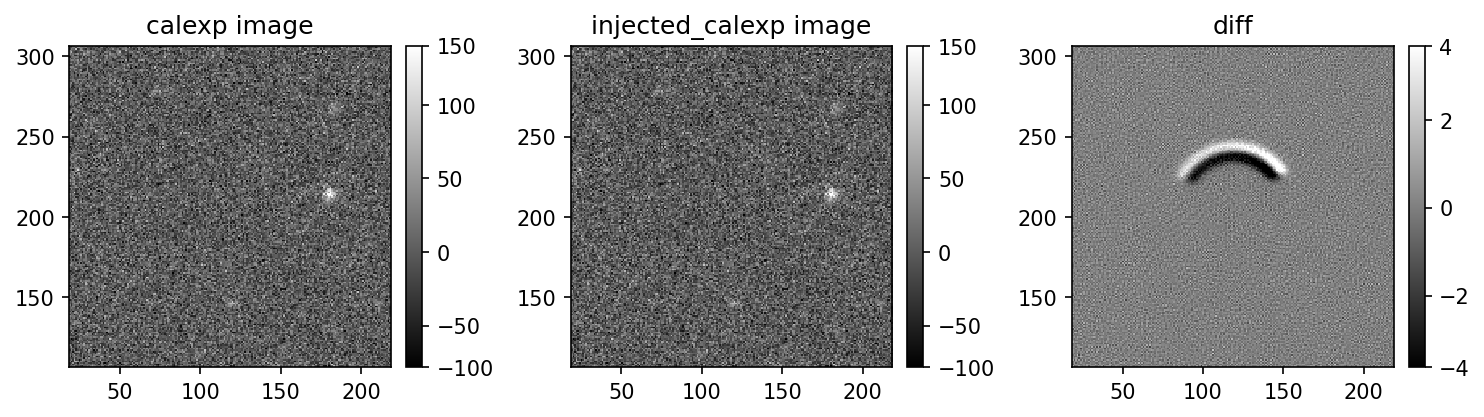

In [48]:
fig, ax = plt.subplots(1, 3, figsize=(10, 6), dpi=150)

plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
display0.scale('linear', 'zscale')
# display0.scale('linear', min=-20, max=150)
display0.mtv(injected_exposure.image[xy[0]+100:xy[0]-100, xy[1]+100:xy[1]-100])#[3510:3560, 1750:1800])
plt.title('calexp image')

plt.sca(ax[1])
display1 = afwDisplay.Display(frame=fig)
display1.scale('linear', 'zscale')
# display1.scale('linear', min=-20, max=150)
# display1.mtv(plot_injected_calexp.image)
# To zoom on the PGC 038749 stamp:
display1.mtv(injected_exposure_230.image[xy[0]+100:xy[0]-100, xy[1]+100:xy[1]-100])#[3510:3560, 1750:1800])
plt.title('injected_calexp image')

plt.sca(ax[2])
display2 = afwDisplay.Display(frame=fig)
display2.scale('linear', 'zscale')
# display1.scale('linear', min=-20, max=150)
# display2.mtv(result.difference.image)
# To zoom on the PGC 038749 stamp:
display2.mtv(result.difference.image[xy[0]+100:xy[0]-100, xy[1]+100:xy[1]-100])#[3510:3560, 1750:1800])
plt.title('diff')

plt.tight_layout()
plt.show()

# Do source detection

# Injection on same calexp doesn't seem correct. I need the same patch of the sky but at different times. Follow DP02_09_Custom_Coadds/DP02_09a_Custom_Coadd.ipynb, and select the pieces of the coadd